
eppstein civil unrest

2 versions in paper
1. general rebellion against central authority
    * covid rules
    * common knowledge twitter
    * situation in Belarus, Myanmar
    * uprising in the US --> deliberate reduction of cops!
    * event based drop of legitimacy (might also work for US case)
    * gradual decline in legitimacy might work for covid

2. central authority trying to repress 2 warring ethnic groups
    * civil war in Syria
    * unrest in Sudan, Ethiopia


# Model description
Below, a mesa implementation is given of Eppstein's Civil Violence model 1. The basic idea of this model is the following. We have 2 types of agents: cops and citizens. Cops and Agents both have a field of vision and they move every step to a random empty location within their field of vision. The agents are all located on a toroidal grid and each grid cell can only be occupied by at most a single agent. 

## Citizen
After having moved, a citizen checks to see if it want to become active. A citizen has a personal level of hardship, and a personal level of risk aversion. All citizens share a perception of the legitimacy of the State and a shared threshold above which they decide to protest. A given citizen bases the decision on whether to protest (i.e., become active) on a couple of things. First grievance is calculated as

$
grievance = hardship * (1-legitimacy)
$

Next, the citizen calculates the net risk of becoming active. The net risk is the perceived chance of being arrested times its personal level of risk aversion. The perceived chance of being arrested is given by

$
p = 1 - e^{(-1*k*round(c/a))}
$

Where $k$ is a constant (set to 2.3 as default), $c$ is the number of cops within the field of vision, and $a$ is the number of active citizens within the field of vision. The citizen now follows a simple rule

*Agent Rule: if G-N > T be active, quiet otherwise*

Where $G$ is the level of grievance, $N$ is the net risk, and $T$ is the activation threshold.

## Cop
After having moved, the cop checks his field of vision for any active citizens. It then arrests a randomly selected active citizen within its field of vision. 

## Arrest
If a citizen is arrested, it cannot move. Upon arrest, a citizen also received a jail time, which is the number of ticks for which it remains under arrest. 

In [8]:
import math
from enum import Enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CitizenState(Enum):
    ACTIVE = 1    
    QUIET = 2    
    JAILED = 3


def count(model, state):
    count = 0
    for agent in model.schedule.agents:
        if isinstance(agent, Cop):
            continue
        else:
            if agent.state == state:
                count += 1
    return count

class CivilViolence(Model):
    """
    Model class for Axelrod's Civil Violence model I.

    """

    def __init__(self, height=40, width=40,
        citizen_density=0.7, citizen_vision=7,
        legitimacy=0.82, activation_treshold=0.1,
        arrest_prob_constant=2.3,
        cop_density=0.04, cop_vision=7,
        max_jail_term=15, seed=None):
        super().__init__(seed=seed)
        assert (citizen_density+cop_density) < 1
        
        # setup Citizen static attributes
        Citizen.vision = citizen_vision
        Citizen.legitimacy = legitimacy
        Citizen.arrest_prob_constant = arrest_prob_constant
        Citizen.activation_threshold = activation_treshold
        
        # setup Cop static attributes
        Cop.vision = cop_vision
        Cop.max_jail_term = max_jail_term

        # setup data collection
        model_reporters = {'active': lambda m: count(m, CitizenState.ACTIVE),
                           'quiet': lambda m: count(m, CitizenState.QUIET),
                           'jailed': lambda m: count(m, CitizenState.JAILED)}
       
        self.datacollector = DataCollector(model_reporters=model_reporters)
        
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        # Set up agents
        id = 1
        for (_, x, y) in self.grid.coord_iter():
            pos = (x,y)
            p = self.random.random()
            if p < citizen_density:
                agent = Citizen(id, self)
            elif p < (citizen_density+cop_density):
                agent = Cop(id, self)
            else:
                continue
            id += 1
            self.grid.position_agent(agent, (x, y))
            self.schedule.add(agent)
        
        self.datacollector.collect(self)
        
    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)


class BaseAgent(Agent):
    moore = False
    
    def update_vision(self):
        '''
        identify cops and active citizens within vision
        '''
        
        cops = []
        actives = []
        
        for cell in self.model.grid.get_neighbors(self.pos,
                         moore=BaseAgent.moore, radius=self.__class__.vision):
            if isinstance(cell, Cop):
                cops.append(cell)
            elif cell.state == CitizenState.ACTIVE:
                actives.append(cell)    
        return cops, actives
    
    def move(self):
        '''
        identify all empty cells within vision and move
        to a randomly selected one.
        '''
        
        empty = []
        for pos in self.model.grid.get_neighborhood(self.pos,
                        moore=BaseAgent.moore, radius=self.__class__.vision):        
            if self.model.grid.is_cell_empty(pos):
                empty.append(pos)
        
        if empty:
            new_pos = self.random.choice(empty)
            self.model.grid.move_agent(self, new_pos)
        
    
class Citizen(BaseAgent):
    # these values are defaults which are set
    # by the model    
    legitimacy = 1
    vision = 1
    arrest_prob_constant = 1
    activation_treshold = 1
    
    @property
    def grievance(self):
        return self.hardship*(1-Citizen.legitimacy)
    
    def __init__(self, identity, model, ):
        super().__init__(identity, model)
        self.hardship = self.random.random()
        self.risk_aversion = self.random.random()
        self.state = CitizenState.QUIET
        self.jail_time_remaining = 0

    def step(self):
        """
        move and then decide whether to activate
        """
        if (self.state == CitizenState.JAILED) and (self.jail_time_remaining > 0):
            self.jail_time_remaining -= 1
            if self.jail_time_remaining > 0:
                return
            
        self.move()
            
        cops, actives = self.update_vision()
        n_cops = len(cops)
        n_actives = len(actives) + 1 # self is always considerd active
            
        arrest_p = 1 - math.exp(-1*Citizen.arrest_prob_constant * round(n_cops / n_actives))
        net_risk = self.risk_aversion * arrest_p
        
        if (self.grievance - net_risk) > self.activation_threshold:
            self.state = CitizenState.ACTIVE
        else:
            self.state = CitizenState.QUIET
        

class Cop(BaseAgent):
    # these values are defaults which are set
    # by the model
    vision = 1
    max_jail_term = 1
        
    def arrest_citizen(self, citizen):
        citizen.state = CitizenState.JAILED
        citizen.jail_time_remaining = self.random.randint(0,Cop.max_jail_term)
        
    def step(self):
        self.move()
        cops, actives = self.update_vision()
        
        if actives:
            to_be_arrested = self.random.choice(actives)
            self.arrest_citizen(to_be_arrested)

            
def visualize_model(model):
    sns.set_style('white')
    colors = sns.color_palette()[0:4]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    positions = []
    color_type = []
    grievance_level = []
    
    for i, (cell, x,y) in enumerate(model.grid.coord_iter()):
        if not cell:
            continue
        
        positions.append([x,y])
        if isinstance(cell, Citizen):
            color_type.append(colors[cell.state.value])
            grievance_level.append(cell.grievance)
        else:
            color_type.append(colors[0])
            grievance_level.append(np.NaN) #dirty hack for masking
    
    positions = np.asarray(positions)
    
    ax1.scatter(positions[:, 0], positions[:, 1], s=15, c=color_type)
    im = ax2.scatter(positions[:, 0], positions[:, 1], s=15, c=grievance_level)
    
    for ax in (ax1, ax2):
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])    
    fig.colorbar(im, cax=cax, orientation='vertical')

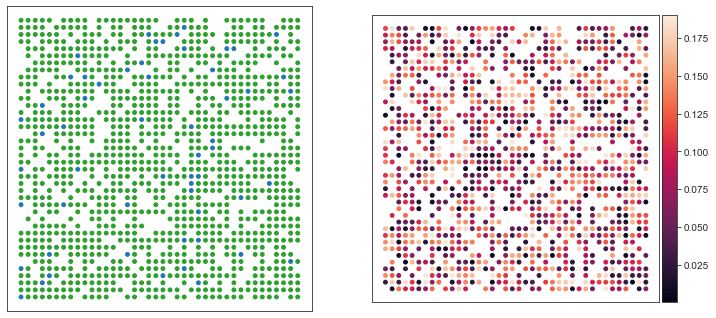

In [9]:
model = CivilViolence(cop_vision=7, citizen_vision=7, legitimacy=0.81,
                      max_jail_term=30, cop_density=0.04, citizen_density=0.7)
visualize_model(model)
for _ in range(500):
    model.step()

<AxesSubplot:>

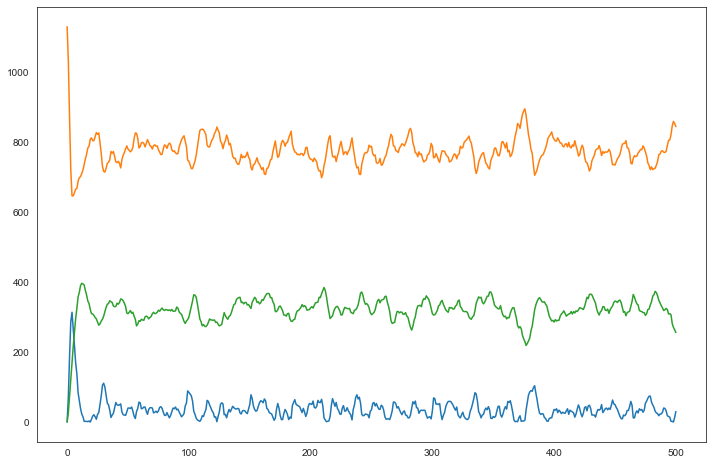

In [10]:
data = model.datacollector.get_model_vars_dataframe()
data.active.plot()
data.quiet.plot()
data.jailed.plot()

<AxesSubplot:>

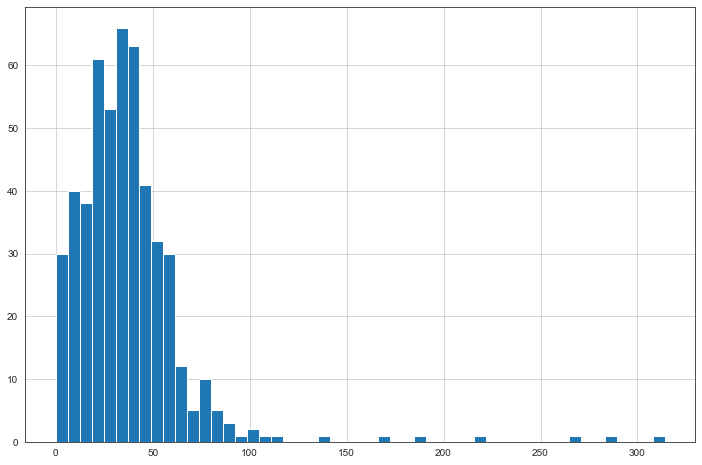

In [11]:
data.active.hist(bins=51)

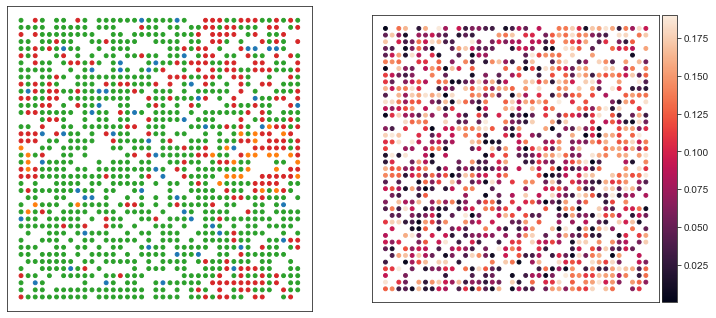

In [12]:
visualize_model(model)
plt.show()